In [101]:
import time
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
#基本参数
batch_size = 128
epoch_num = 2000
data_path='bike-sharing-dataset/hour.csv'

In [102]:
#数据处理
rides = pd.read_csv(data_path)
# 形成one-hot编码
dummy_fields = ['season','weathersit','mnth','hr','weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each,drop_first=False)
    rides = pd.concat([rides,dummies], axis=1)
#把原有的类型特征去掉，将一些不相关的特征去掉
fields_to_drop = ['instant', 'dteday', 'season','weathersit','weekday', 'atemp', 'mnth','workingday','hr']
data = rides.drop(fields_to_drop,axis=1)
#调整所有的特征，标准化处理
quant_features = ['cnt','temp','hum','windspeed']
scaled_features = {}
for each in quant_features:
    mean,std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean,std]
    data.loc[:,each] = (data[each] - mean) / std

In [103]:
#将所有的数据集分为测试集和训练集，我们以后21天数据一共21*24个数据点作为测试集，其它是训练集
test_data = data[-21 * 24:]
train_data = data[:-21 * 24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))
#将我们的数据列分为特征列和目标列
target_fields = ['cnt','casual','registered']
features,targets = train_data.drop(target_fields,axis=1), train_data[target_fields]
test_features,test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
#将数据从pandas dataframe转换为numpy,在转化成tensor
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)
Y = np.reshape(Y,[len(Y),1])
X_t = test_features.values
Y_t = test_targets['cnt'].values
Y_t = Y_t.astype(float)
Y_t = np.reshape(Y_t,[len(Y_t),1])

X = torch.FloatTensor(X.astype(float))
Y = torch.FloatTensor(Y)
X_t = torch.FloatTensor(X_t.astype(float))
Y_c = torch.sign(torch.sign(Y) + 1).flatten().long()#将Y变为0，1分布,交叉嫡函数的target数据只能是一维长整型张量
Y_ct = np.sign(np.sign(Y_t) + 1)#用于计算分类准确率

input_size2 = features.shape[1]
hidden_size2 = 10
output_size2 = 2

训练数据： 16875 测试数据： 504


In [104]:
Y_ct.shape

(504, 1)

In [105]:
neu2 = torch.nn.Sequential(
    torch.nn.Linear(input_size2,hidden_size2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size2,output_size2),
)
cost2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params=neu2.parameters(),lr=0.01)

#训练模型
def train2(epoch_num,X, Y, is_cuda=0):
    if is_cuda == 1:
        X, Y = X.cuda(),Y.cuda()
        neu2.cuda()
    for epoch in range(epoch_num):
#每128个样本点被划分为一个撮，在循环的时候一批一批地读取# start和end分别是提取一个batch数据的起始和终止下标
        for start in range(0,len(X),batch_size):
            end = start + batch_size if start + batch_size < len(X) else len(X)
            xx= X[start:end]
            yy = Y_c[start:end]
            predict = neu2(xx)
            loss2 = cost2(predict,yy)#注意这里要输入一个一维的数据Y
            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()
        if epoch+1 in [1,10,50,100,500,1000,1500,2000] :#epoch % 100 == 99:
            test_plot2(epoch)

In [106]:
#绘制训练动态图
def test_plot2(epoch):
    plt.cla()
    #prediction
    predict=neu2(X_t)
    _,c=torch.max(predict,dim=1)
    c=c.data.numpy().reshape(-1,1)
    correct = (c == Y_ct).sum()
    accuracy = correct / 504
    print('epoch={}\tAccuracy : {:.3%}'.format(epoch + 1,accuracy))#将后21天的预测数据与真实数据画在一起并比较

    mean, std = scaled_features['cnt']
    plt.scatter(range(504),Y_t * std + mean,c=c)
    plt.plot([-30,550],[mean,mean], linewidth=2)
    plt.xlabel('Date-time')
    plt.ylabel('Counts')

    #对横坐标轴进行标注
    dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    plt.xticks(np.arange(len(dates))[12::24], dates[12::24],rotation=90)
    plt.text(350, 550, 'epoch={} \nAccuracy : {:.3%}'.format(epoch + 1,accuracy),fontsize=10)
    if epoch == epoch_num - 1:
        t2 = time.time()
        print('time of train:',t2 - t1)
        plt.show()
    else:
        plt.pause(0.001)


epoch=1	Accuracy : 57.738%


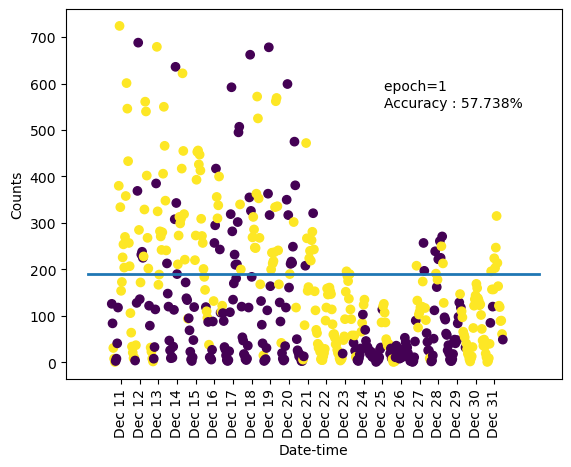

epoch=10	Accuracy : 71.032%


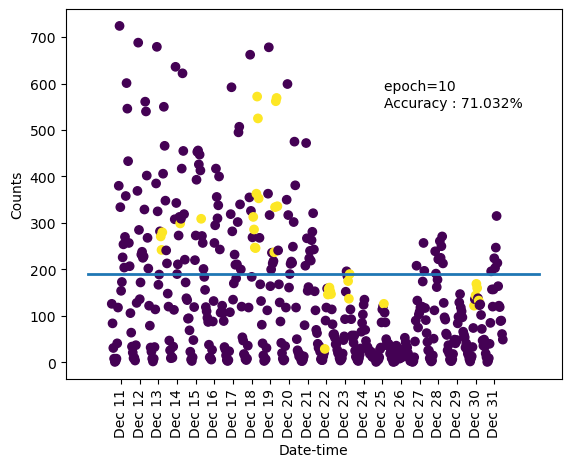

epoch=50	Accuracy : 84.325%


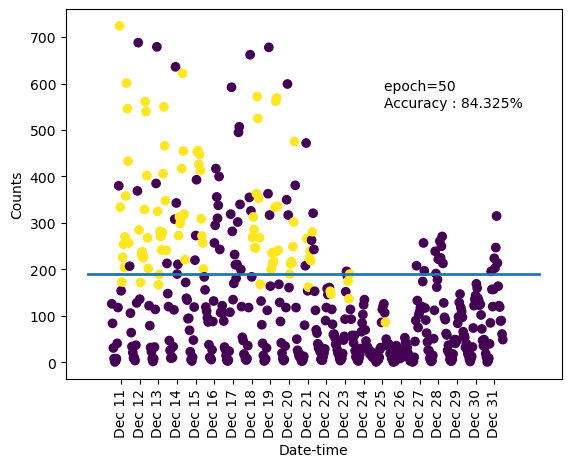

epoch=100	Accuracy : 86.508%


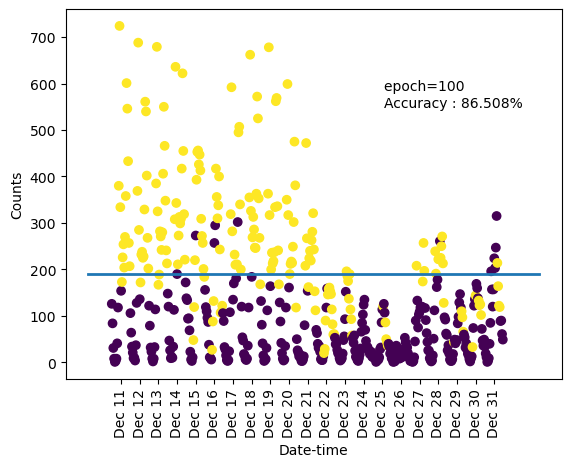

epoch=500	Accuracy : 81.746%


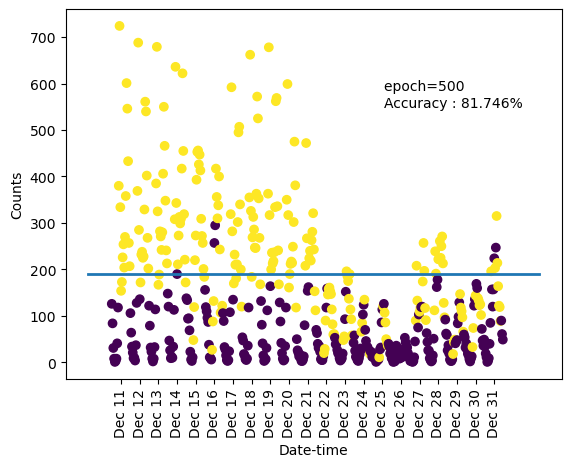

epoch=1000	Accuracy : 82.540%


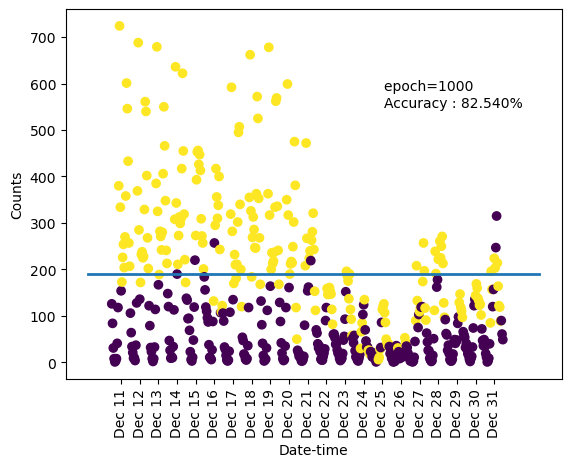

epoch=1500	Accuracy : 84.722%


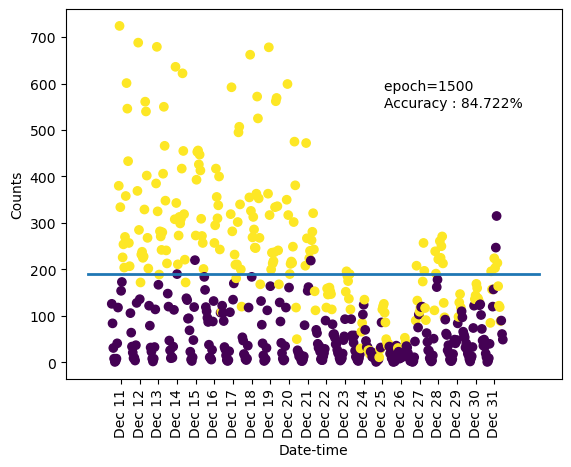

epoch=2000	Accuracy : 86.111%
time of train: 145.48251223564148


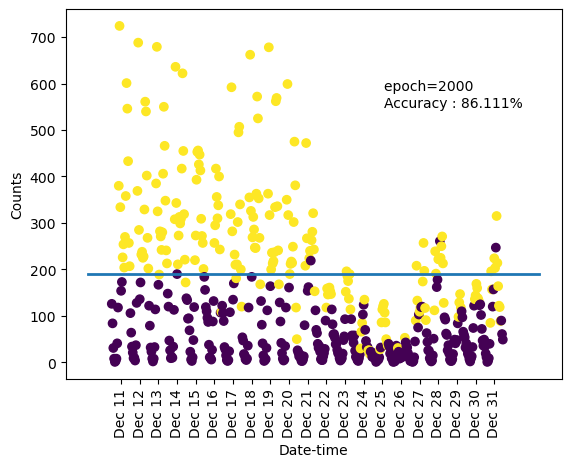

In [107]:
t1=time.time()
train2(epoch_num,X,Y,is_cuda=0)